N=9, 12, 15
Used MLP method

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [12]:


# Define Earlystopping Class
class EarlyStopping:
    def __init__(self, patience=7, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

#Define MLP Class
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        layers = []
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.LeakyReLU())
            input_size = hidden_size
        layers.append(nn.Linear(input_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Plot curves
def plot_training_curves(training_losses, validation_losses, validation_accuracies, target_acc):
    import matplotlib.pyplot as plt
    epochs = range(1, len(training_losses) + 1)

    plt.figure(figsize=(14, 6))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_losses, label="Training Loss")
    plt.plot(epochs, validation_losses, label="Validation Loss")
    #plt.axhline(y=target_acc, color='r', linestyle='--', label="Target Accuracy")
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, validation_accuracies, label="Validation Accuracy")
    plt.axhline(y=target_acc, color='b', linestyle='--', label="Target Accuracy")
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Train & evaluate with MLP model
def train_and_evaluate_mlp(n, e, epochs=100, batch_size=32, patience=10, learning_rate=0.001, hidden_sizes=[256, 128, 64]):
    # Preprocess data(Load, Split, etc)
    X = np.load(f'../Datasets/kryptonite-{n}-X.npy')
    y = np.load(f'../Datasets/kryptonite-{n}-y.npy')
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    poly = PolynomialFeatures(degree=e)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    X_test_poly = poly.transform(X_test)

    scaler = StandardScaler()
    X_train_poly = scaler.fit_transform(X_train_poly)
    X_val_poly = scaler.transform(X_val_poly)
    X_test_poly = scaler.transform(X_test_poly)

    device = torch.device("cpu")
    X_train_tensor = torch.tensor(X_train_poly, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    X_val_tensor = torch.tensor(X_val_poly, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)
    X_test_tensor = torch.tensor(X_test_poly, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

    # Initialize MLP model
    input_size = X_train_poly.shape[1]
    output_size = len(np.unique(y_train))
    model = MLP(input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    early_stopping = EarlyStopping(patience=patience)

    # Train Loop
    training_losses, validation_losses, validation_accuracies = [], [], []
    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(X_train_tensor.size(0))
        epoch_loss = 0
        for i in range(0, X_train_tensor.size(0), batch_size):
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor).item()
            val_predictions = torch.argmax(val_outputs, dim=1).cpu().numpy()
            val_accuracy = accuracy_score(y_val, val_predictions)

        # Mark and Print output
        training_losses.append(epoch_loss)
        validation_losses.append(val_loss)
        validation_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Evaluate test result
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_predictions = torch.argmax(test_outputs, dim=1).cpu().numpy()
        test_accuracy = accuracy_score(y_test, test_predictions)
    
    print(f"n={n}, e={e}, Test Accuracy={test_accuracy:.4f}")

    target_acc = targetPerformance(n)
    print(f"Target Accuracy: {target_acc:.4f}")

    plot_training_curves(training_losses, validation_losses, validation_accuracies, target_acc)

Training and evaluating for n=9, e=1
Epoch 1/100, Training Loss: 227.7177, Validation Loss: 0.4660, Validation Accuracy: 0.8206
Epoch 2/100, Training Loss: 78.7372, Validation Loss: 0.1886, Validation Accuracy: 0.9575
Epoch 3/100, Training Loss: 64.3828, Validation Loss: 0.1866, Validation Accuracy: 0.9594
Epoch 4/100, Training Loss: 61.9235, Validation Loss: 0.1906, Validation Accuracy: 0.9578
Epoch 5/100, Training Loss: 60.7134, Validation Loss: 0.1850, Validation Accuracy: 0.9603
Epoch 6/100, Training Loss: 59.0177, Validation Loss: 0.1835, Validation Accuracy: 0.9592
Epoch 7/100, Training Loss: 57.8258, Validation Loss: 0.1862, Validation Accuracy: 0.9600
Epoch 8/100, Training Loss: 57.1928, Validation Loss: 0.1934, Validation Accuracy: 0.9578
Epoch 9/100, Training Loss: 56.7508, Validation Loss: 0.1960, Validation Accuracy: 0.9586
Epoch 10/100, Training Loss: 56.4113, Validation Loss: 0.1870, Validation Accuracy: 0.9603
Epoch 11/100, Training Loss: 55.9605, Validation Loss: 0.2003

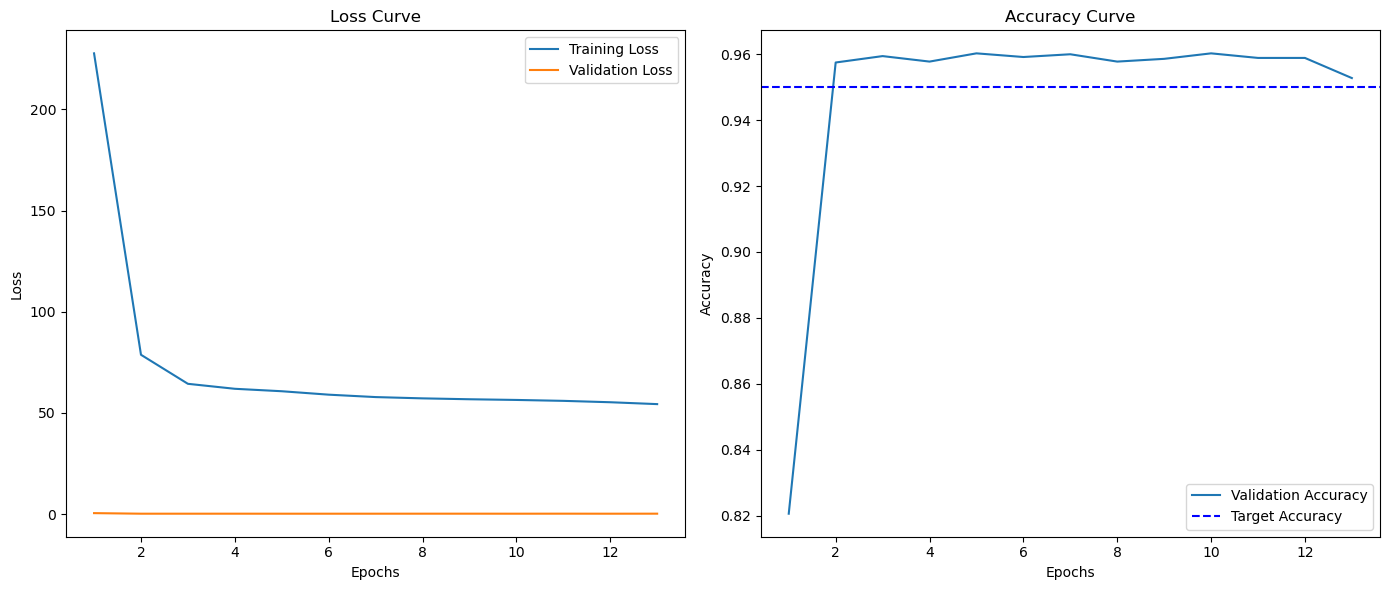



Training and evaluating for n=12, e=1
Epoch 1/100, Training Loss: 312.0747, Validation Loss: 0.6934, Validation Accuracy: 0.5029
Epoch 2/100, Training Loss: 311.5784, Validation Loss: 0.6933, Validation Accuracy: 0.5062
Epoch 3/100, Training Loss: 296.0115, Validation Loss: 0.4827, Validation Accuracy: 0.7756
Epoch 4/100, Training Loss: 133.6134, Validation Loss: 0.2360, Validation Accuracy: 0.9298
Epoch 5/100, Training Loss: 88.2088, Validation Loss: 0.1990, Validation Accuracy: 0.9510
Epoch 6/100, Training Loss: 78.3650, Validation Loss: 0.1987, Validation Accuracy: 0.9504
Epoch 7/100, Training Loss: 73.0285, Validation Loss: 0.1872, Validation Accuracy: 0.9548
Epoch 8/100, Training Loss: 70.4506, Validation Loss: 0.1840, Validation Accuracy: 0.9550
Epoch 9/100, Training Loss: 69.5940, Validation Loss: 0.1921, Validation Accuracy: 0.9531
Epoch 10/100, Training Loss: 67.2256, Validation Loss: 0.1871, Validation Accuracy: 0.9529
Epoch 11/100, Training Loss: 66.2398, Validation Loss: 

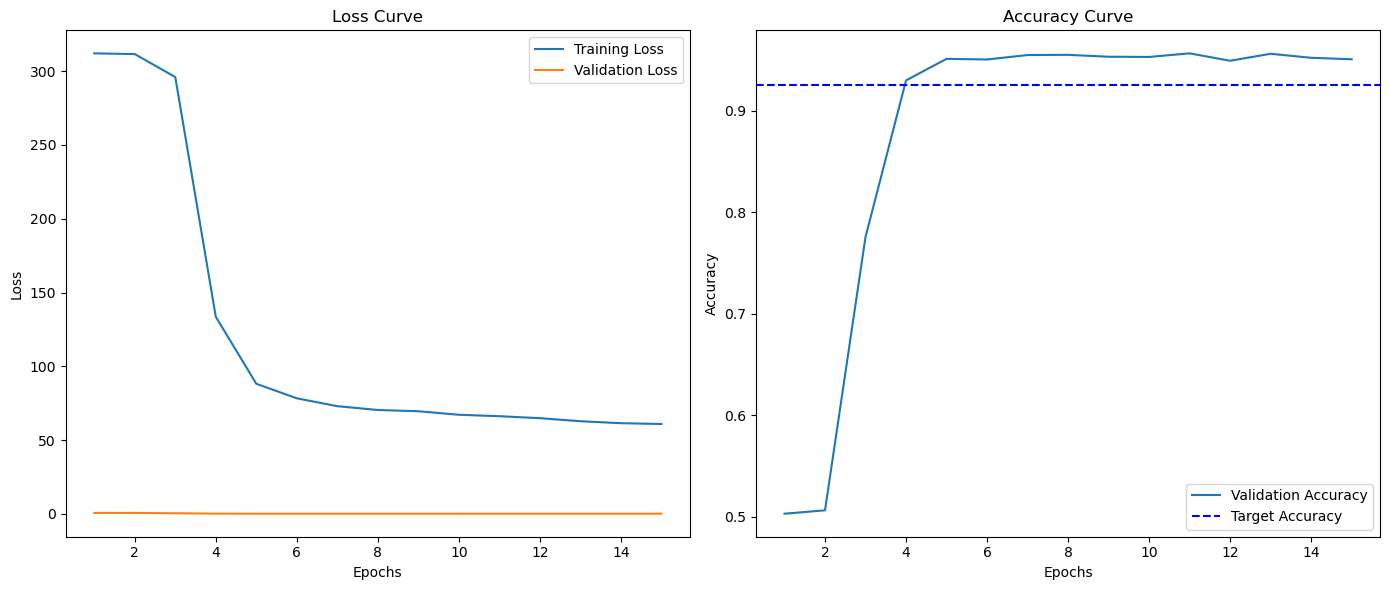



Training and evaluating for n=15, e=1
Epoch 1/100, Training Loss: 390.6212, Validation Loss: 0.6934, Validation Accuracy: 0.4995
Epoch 2/100, Training Loss: 390.2425, Validation Loss: 0.6936, Validation Accuracy: 0.4993
Epoch 3/100, Training Loss: 389.7780, Validation Loss: 0.6936, Validation Accuracy: 0.5037
Epoch 4/100, Training Loss: 388.9573, Validation Loss: 0.6962, Validation Accuracy: 0.5122
Epoch 5/100, Training Loss: 384.2553, Validation Loss: 0.6688, Validation Accuracy: 0.5775
Epoch 6/100, Training Loss: 293.4748, Validation Loss: 0.4028, Validation Accuracy: 0.8282
Epoch 7/100, Training Loss: 186.7582, Validation Loss: 0.3292, Validation Accuracy: 0.8787
Epoch 8/100, Training Loss: 151.7943, Validation Loss: 0.3172, Validation Accuracy: 0.8892
Epoch 9/100, Training Loss: 133.1684, Validation Loss: 0.2851, Validation Accuracy: 0.9063
Epoch 10/100, Training Loss: 123.8720, Validation Loss: 0.2730, Validation Accuracy: 0.9085
Epoch 11/100, Training Loss: 115.5576, Validation

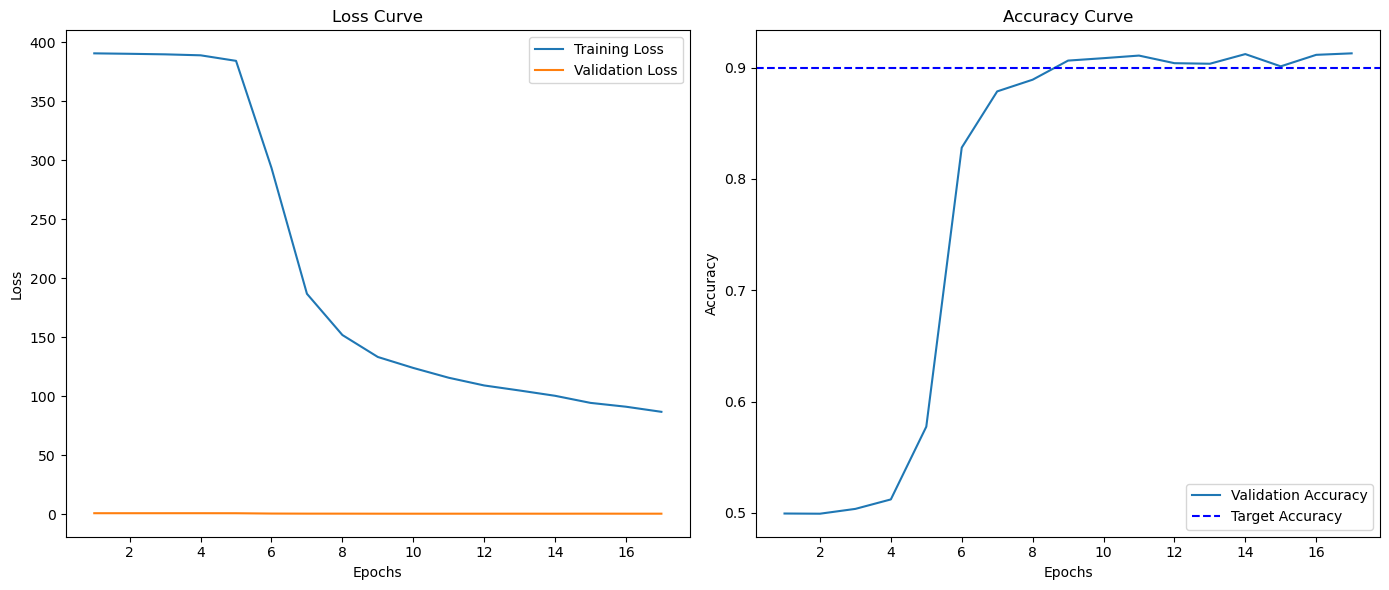

In [13]:
n_values = [9, 12, 15]
e = 1
for n in n_values:
    print(f"Training and evaluating for n={n}, e={e}")
    train_and_evaluate_mlp(n=n, e=e, epochs=100, batch_size=32, patience=7, learning_rate=0.001, hidden_sizes=[256, 128, 64])
    print("\n")
